## 《合成孔径雷达成像——算法与实现》中第6章 距离多普勒算法

距离多普勒算法（RD算法）的基本思想是根据上述将二维处理分解为两个一维处理的级联形式，其特点是只考虑相位展开的一次项，将距离压缩后的数据沿方位向作FFT，变换到距离多普勒域，然后完成距离迁移校正和方位向压缩。

如下图是距离多普勒算法的三种实现方案

[![图6.1 RDA的三种实现框图](图片1.jpg)]

(a)给出的是适合小斜视角及短孔径下的基本RDA处理算法，(b)是斜视处理所需的二次距离压缩改进算法，其中二次距离压缩为二维频域中的精确实现，(c)是二次距离压缩的近似距离频域实现，与(b)相比，其效率较高。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

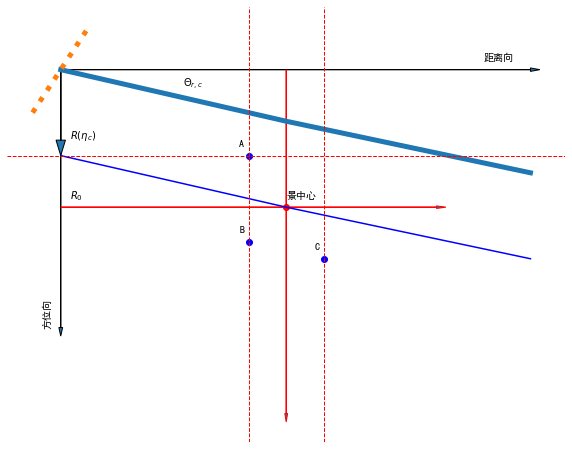

In [2]:
from matplotlib.pyplot import figure,subplot,plot,axis,title,suptitle,xlabel,ylabel,text,arrow,tight_layout
# 绘图
figure(figsize=(10,8));
plt.xticks([])
plt.yticks([])
plt.axis('off')
arrow(0, 0, 50, 0, width = 0.01, head_width=0.4, head_length=1, ec ='black') 
arrow(0, 0, 0, -30, width = 0.01, head_width=0.4, head_length=1, ec ='black') 
arrow(0, -16, 40, 0, width = 0.005, head_width=0.3, head_length=1, ec ='red') 
arrow(24, 0, 0, -40, width = 0.005, head_width=0.3, head_length=1, ec ='red') 
arrow(0, 0, 0, -8.2, width = 0.01, head_width=1.0, head_length=1.8, ec ='black') 
text(45,1,'距离向');text(-2,-30,'方位向',rotation=90)
xlist = [20,20,28]
ylist = [-10,-20,-22]
plt.plot(xlist,ylist,'bo')
plt.plot([24],[-16],'ro')
xlist = [0,24,50]
ylist = [-10,-16, -22.0]
plt.plot(xlist,ylist,'b-')
xlist = [0,24,50]
ylist = [0,-6, -12.0]
plt.plot(xlist,ylist,linewidth = '5')
xlist = [-3,3]
ylist = [-5,5]
plt.plot(xlist,ylist,linewidth = '5',linestyle=':')
plt.axvline(x= 20, c="r", ls="--", lw=1)
plt.axvline(x= 28, c="r", ls="--", lw=1)
plt.axhline(y= -10, c="r", ls="--", lw=1)
text(24,-15,'景中心');text(19,-9,'A');text(19,-19,'B');text(27,-21,'C')
text(1,-15,'$R_0$');text(1,-8,'$R(\eta_c)$');text(13,-2,'$ \Theta _{r,c}$');


距离向和方位向的观测中心选取：距离向观测时间中心应该选为$2R(\eta_c)$，方位向观测时间中心应该选为$\eta_c$。这是因为雷达回波数据都以这两个时刻为中心分布，如此方能在原始雷达图像中观测到目标点数据。

目标点位置的设置：目标点的波束中心穿越时刻应该与景中心的波束中心穿越时刻相近，即目标点的波束中心穿越时刻斜距应该与景中心斜距相近，这样我们才能在有效的观测范围内观测到全部目标点。

距离徙动校正时距离向的观测中心选取：距离轴的中心应该选为$R_0=R(\eta_c)cos \theta_{r,c}$。这是因为距离徙动校正后，目标数据点都会移动到自己的最近斜距处，若仍以$R(\eta_c)$作为距离轴的中心，则会导致距离徙动校正错误。

In [3]:
from numpy import pi,abs,max,min,argmax,argmin,ceil,exp,sqrt,real,imag,conj,sinc,sin,cos,tan,arctan,log10,angle,unwrap
from numpy import linspace,arange,zeros,ones,concatenate,convolve
from numpy.fft import fft,fftshift,ifft,ifftshift,fft2,ifft2
from matplotlib.pyplot import figure,subplot,plot,axis,title,suptitle,xlabel,ylabel,text,arrow,tight_layout

In [4]:
## 参数设置
#  已知参数--》距离向参数
R_eta_c = 20e+3;                # 景中心斜距
Tr = 2.5e-6;                    # 发射脉冲时宽
Kr = 20e+12;                    # 距离向调频率
alpha_os_r = 1.2;               # 距离过采样率
Nrg = 320;                      # 距离线采样点数
#  计算参数--》距离向参数
Bw = abs(Kr)*Tr;                # 距离信号带宽
Fr = alpha_os_r*Bw;             # 距离向采样率
Nr = int(np.round(Fr*Tr));              # 距离采样点数(脉冲序列长度)
#  已知参数--》方位向参数
c = 3e+8;                       # 电磁传播速度
Vr = 150;                       # 等效雷达速度
Vs = Vr;                        # 卫星平台速度
Vg = Vr;                        # 波束扫描速度
f0 = 5.3e+9;                    # 雷达工作频率
Delta_f_dop = 80;               # 多普勒带宽
alpha_os_a = 1.25;              # 方位过采样率
Naz = 256;                      # 距离线数
theta_r_c = +3.5*pi/180;        # 波束斜视角
#  计算参数--》方位向参数
lambda0 = c/f0;                  # 雷达工作波长
t_eta_c = -R_eta_c*sin(theta_r_c)/Vr;
                                # 波束中心穿越时刻
f_eta_c = 2*Vr*sin(theta_r_c)/lambda0;
                                # 多普勒中心频率
La = 0.886*2*Vs*cos(theta_r_c)/Delta_f_dop;               
                                # 实际天线长度
Fa = alpha_os_a*Delta_f_dop;    # 方位向采样率
Ta = 0.886*lambda0*R_eta_c/(La*Vg*cos(theta_r_c));
                                # 目标照射时间
R0 = R_eta_c*cos(theta_r_c);    # 最短斜距
Ka = 2*Vr**2*cos(theta_r_c)**2/lambda0/R0;              
                                # 方位向调频率
theta_bw = 0.886*lambda0/La;     # 方位向3dB波束宽度
theta_syn = Vs/Vg*theta_bw;     # 合成角宽度
Ls = R_eta_c*theta_syn;         # 合成孔径长度
#  参数计算
rho_r = c/(2*Fr);               # 距离向分辨率
rho_a = La/2;                   # 距离向分辨率
Trg = Nrg/Fr;                   # 发射脉冲时宽
Taz = Naz/Fa;                   # 目标照射时间
d_t_tau = 1/Fr;                 # 距离采样时间间隔
d_t_eta = 1/Fa;                 # 方位采样时间间隔
d_f_tau = Fr/Nrg;               # 距离采样频率间隔    
d_f_eta = Fa/Naz;               # 方位采样频率间隔
## 目标设置
#  设置目标点相对于景中心之间的距离
A_r =   0; A_a =   0;                                   # A点位置
B_r = -50; B_a = -50;                                   # B点位置
C_r = -50; C_a = +50;                                   # C点位置
D_r = +50; D_a = C_a + (D_r-C_r)*tan(theta_r_c);        # D点位置
#  得到目标点相对于景中心的位置坐标
A_x = R0 + A_r; A_Y = A_a;                              # A点坐标
B_x = R0 + B_r; B_Y = B_a;                              # B点坐标
C_x = R0 + C_r; C_Y = C_a;                              # C点坐标
D_x = R0 + D_r; D_Y = D_a;                              # D点坐标
NPosition = np.array([[A_x,A_Y],
             [B_x,B_Y],
             [C_x,C_Y],
             [D_x,D_Y]      ])                          # 设置数组
# fprintf( 'A点坐标为[#+3.3f，#+3.3f]km\n', NPosition(1,1)/1e3, NPosition(1,2)/1e3 );
# fprintf( 'B点坐标为[#+3.3f，#+3.3f]km\n', NPosition(2,1)/1e3, NPosition(2,2)/1e3 );
# fprintf( 'C点坐标为[#+3.3f，#+3.3f]km\n', NPosition(3,1)/1e3, NPosition(3,2)/1e3 );
# fprintf( 'D点坐标为[#+3.3f，#+3.3f]km\n', NPosition(4,1)/1e3, NPosition(4,2)/1e3 );
#  得到目标点的波束中心穿越时刻
Ntarget = 4;
Tar_t_eta_c = zeros(Ntarget);
for i in range( Ntarget ):
    DeltaX = NPosition[i][1] - NPosition[i][0]*tan(theta_r_c);
    Tar_t_eta_c[i] = DeltaX/Vs;

#  得到目标点的绝对零多普勒时刻
Tar_t_eta_0 = zeros(Ntarget);
for i in range( Ntarget ):
    Tar_t_eta_0[i] = NPosition[i][1]/Vr;

## 变量设置
#  时间变量 以景中心的零多普勒时刻作为方位向零点
t_tau = arange(-Trg/2,Trg/2,d_t_tau) + 2*R_eta_c/c;   # 距离时间变量
t_eta = arange(-Taz/2,Taz/2,d_t_eta) + t_eta_c;       # 方位时间变量
#  长度变量
r_tau = (t_tau*c/2)*cos(theta_r_c);                     # 距离长度变量
#  频率变量 
f_tau = fftshift(arange(-Fr/2,Fr/2,d_f_tau));           # 距离频率变量
f_tau = f_tau - np.round((f_tau-0)/Fr)*Fr;                 # 距离频率变量(可观测频率)  
f_eta = fftshift(arange(-Fa/2,Fa/2,d_f_eta));           # 方位频率变量
f_eta = f_eta - np.round((f_eta-f_eta_c)/Fa)*Fa;           # 方位频率变量(可观测频率)
## 坐标设置     
#  以距离时间为X轴，方位时间为Y轴
t_tauX,t_etaY = np.meshgrid(t_tau,t_eta);                # 设置距离时域-方位时域二维网络坐标
#  以距离长度为X轴，方位频率为Y轴                                                                                                            
r_tauX,f_etaY = np.meshgrid(r_tau,f_eta);                # 设置距离时域-方位频域二维网络坐标
#  以距离频率为X轴，方位频率为Y轴                                                                                                            
f_tau_X,f_eta_Y = np.meshgrid(f_tau,f_eta);              # 设置频率时域-方位频域二维网络坐标
## 信号设置--》原始回波信号                                                        

In [5]:
st_tt = zeros((Naz,Nrg),dtype='complex');
for i in range(Ntarget):
    #  计算目标点的瞬时斜距
    R_eta = sqrt( NPosition[i][0]**2 + Vr**2*(t_etaY-Tar_t_eta_0[i])**2 ); 
    #{
#     R_eta = NPosition[i][0] + Vr**2*t_etaY**2/(2*NPosition[i][0]);   
    #}
    #  后向散射系数幅度
    A0 = ones(4)*exp(+1j*0);   
    #  距离向包络
    wr = np.where(abs(t_tauX-2*R_eta/c) <= Tr/2,1,0);                               
    #  方位向包络
    wa = sinc(0.886*arctan(Vg*(t_etaY-Tar_t_eta_c[i])/NPosition[i][0])/theta_bw)**2;      
    #  接收信号叠加
    st_tt_tar = A0[i]*wr*wa*exp(-1j*4*pi*f0*R_eta/c)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2); 
    #{
#     st_tt_tar = A0[i]*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);
    #}                                                          
    st_tt = st_tt + st_tt_tar;  
    


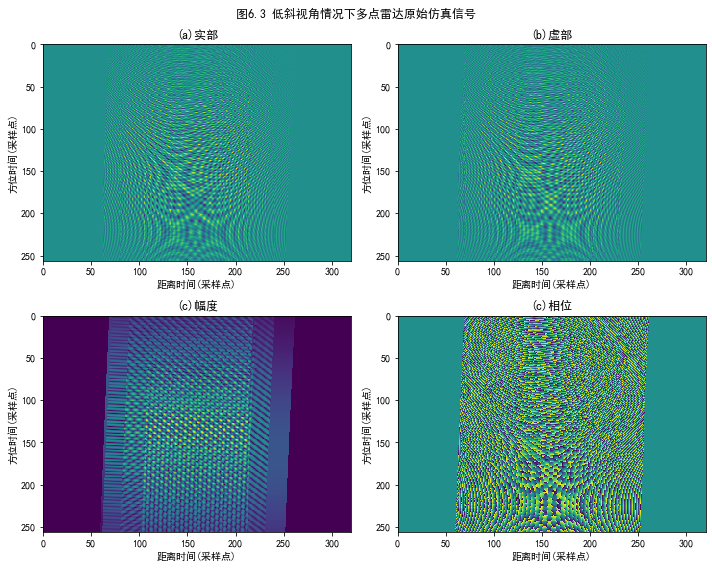

In [25]:
figure(figsize=(10,8));
             
subplot(221),plt.pcolor( real(st_tt))             
xlabel('距离时间(采样点)'),ylabel('方位时间(采样点)'),title('(a)实部');
plt.gca().invert_yaxis()
subplot(222),plt.pcolor( imag(st_tt))
xlabel('距离时间(采样点)'),ylabel('方位时间(采样点)'),title('(b)虚部');
plt.gca().invert_yaxis()
subplot(223),plt.pcolor(  abs(st_tt)) 
xlabel('距离时间(采样点)'),ylabel('方位时间(采样点)'),title('(c)幅度');
plt.gca().invert_yaxis()
subplot(224),plt.pcolor(angle(st_tt))
xlabel('距离时间(采样点)'),ylabel('方位时间(采样点)'),title('(c)相位');
plt.gca().invert_yaxis()
suptitle('图6.3 低斜视角情况下多点雷达原始仿真信号')
plt.tight_layout()

Text(0.5, 0.98, '图6.4 方式一得到距离压缩后的仿真结果')

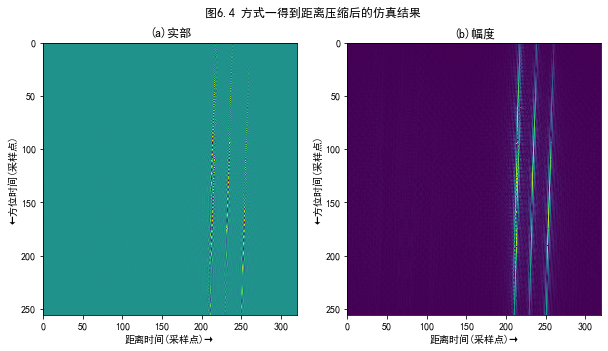

In [26]:
## 信号设置--》一次距离压缩                  
#  变量设置
dt = Tr/Nr;                                             # 脉冲时间间隔
ttau = arange(-Tr/2,Tr/2,dt);                                # 脉冲时间变量
# #{
# ttau = arange(-Nr/2,Nr/2,1)/Fr;                               # 脉冲时间变量
# #}
# #{
# ttau = linspace(-Nr/2,Nr/2,Nr)/Fr;                      # 脉冲时间变量
# #}
#  计算滤波器
#  信号变换-->方式一：复制脉冲，时间反褶后取复共轭，补零DFT得到频域匹配滤波器
#  加窗函数
window_1 = np.kaiser(Nr,2.5);                             # 时域窗
Window_1 = fftshift(window_1);                          # 频域窗
hrt_1 = np.where(abs(ttau)<=Tr/2,1,0)*exp(+1j*pi*Kr*ttau**2);      # 复制脉冲
hrt_window_1 = Window_1.reshape(1,Nr)*hrt_1;                         # 加窗
Hrf_1 = np.tile(fft(conj(np.fliplr(hrt_window_1)),Nrg),(Naz,1));                        
#  信号变换-->方式二：复制脉冲，补零DFT，取复共轭得到频域匹配滤波器无时间反褶
window_2 = np.kaiser(Nr,2.5);                             # 时域窗
Window_2 = fftshift(window_2);                          # 频域窗
hrt_2 = np.where(abs(ttau)<=Tr/2,1,0)*exp(+1j*pi*Kr*ttau**2);      # 复制脉冲
hrt_window_2 = Window_2.reshape(1,Nr)*hrt_2;                         # 加窗
Hrf_2 = np.tile(conj(fft(hrt_window_2,Nrg)),(Naz,1));                   
#  信号变换-->方式三：根据脉冲频谱特性直接在频域生成频域匹配滤波器
window_3 = np.kaiser(Nrg,2.5);                             # 时域窗
Window_3 = fftshift(window_3);                          # 频域窗
Window_3 = np.concatenate((Window_3[:int(ceil(Nr/2))],zeros(Nrg-Nr,dtype='complex'),Window_3[int(ceil(Nr/2)):Nr]))
Window_3 = np.tile(Window_3,(256,1));
Hrf_3 = np.where(abs(f_tau_X)<=Bw/2,1,0)*Window_3*exp(+1j*pi*f_tau_X**2/Kr);  
#  匹配滤波
Sf_ft = fft(st_tt,Nrg,axis=1);
Srf_tf_1 = Sf_ft*Hrf_1;
srt_tt_1 = ifft(Srf_tf_1,Nrg,axis=1);
Srf_tf_2 = Sf_ft*Hrf_2;
srt_tt_2 = ifft(Srf_tf_2,Nrg,axis=1);
Srf_tf_3 = Sf_ft*Hrf_3;
srt_tt_3 = ifft(Srf_tf_3,Nrg,axis=1);
#  绘图
H2 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(srt_tt_1))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(a)实部')
subplot(122),plt.pcolor( abs(srt_tt_1))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(b)幅度')#  信号变换-->方式三：根据脉冲频谱特性直接在频域生成频域匹配滤波器
#  加窗函数
plt.suptitle( '图6.4 方式一得到距离压缩后的仿真结果')


Text(0.5, 0.98, '图6.4 方式三得到距离压缩后的仿真结果')

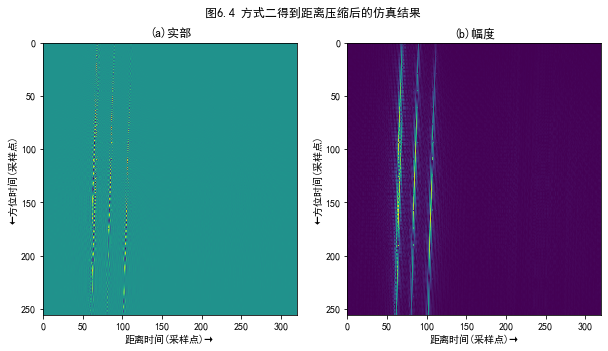

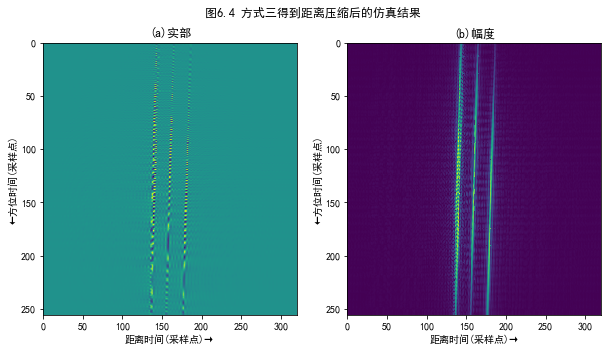

In [27]:
#  绘图
H3 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(srt_tt_2))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(a)实部')
subplot(122),plt.pcolor( abs(srt_tt_2))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(b)幅度')
suptitle('图6.4 方式二得到距离压缩后的仿真结果')
#  绘图
H4 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(srt_tt_3))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(a)实部')
subplot(122),plt.pcolor( abs(srt_tt_3))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(b)幅度')
suptitle('图6.4 方式三得到距离压缩后的仿真结果')

Text(0.5, 0.98, '图6.5 方位向快速傅里叶变换后的仿真结果')

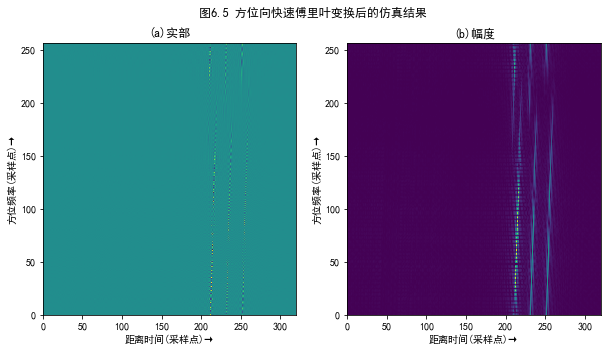

In [9]:
## 信号设置--》方位向傅里叶变换
Saf_tf_1 = fft(srt_tt_1,Naz,axis=0);
Saf_tf_2 = fft(srt_tt_2,Naz,axis=0);
Saf_tf_3 = fft(srt_tt_3,Naz,axis=0);
#  绘图
H5 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(Saf_tf_1))#,set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(a)实部')
subplot(122),plt.pcolor( abs(Saf_tf_1))#,set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(b)幅度')
suptitle('图6.5 方位向快速傅里叶变换后的仿真结果')

Text(0.5, 0.98, '图6.5 方位向快速傅里叶变换后的仿真结果')

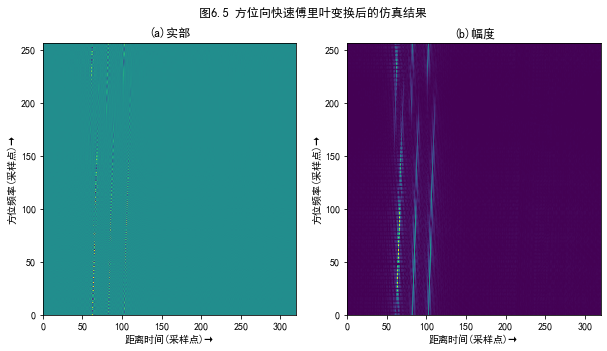

In [10]:
H6 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(Saf_tf_2))#,set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(a)实部')
subplot(122),plt.pcolor( abs(Saf_tf_2))#,set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(b)幅度')
suptitle('图6.5 方位向快速傅里叶变换后的仿真结果')

Text(0.5, 0.98, '图6.5 方位向快速傅里叶变换后的仿真结果')

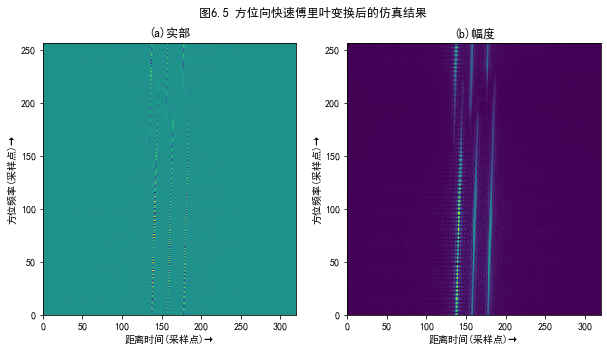

In [11]:
#  绘图
H7 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(Saf_tf_3))#,set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(a)实部')
subplot(122),plt.pcolor( abs(Saf_tf_3))#,set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(b)幅度')
suptitle('图6.5 方位向快速傅里叶变换后的仿真结果')

In [12]:
## 信号设置--》距离徙动校正
RCM = lambda0**2*r_tauX*f_etaY**2/(8*Vr**2);              # 需要校正的距离徙动量
RCM = R0 + RCM - R_eta_c;                               # 将距离徙动量转换到原图像坐标系中
offset = RCM/rho_r;                                     # 将距离徙动量转换为距离单元偏移量
#  计算插值系数表
              
x_tmp = np.tile(arange(-4,4,1),(16,1));                            # 插值长度                          
x_tmp = x_tmp + np.tile((arange(1,17,1)/16).reshape(16,1),(1,8));            # 量化位移
hx = sinc(x_tmp);                                       # 生成插值核
kwin = np.tile(np.kaiser(8,2.5),(16,1));                  # 加窗
hx = kwin*hx;
sm = np.sum(hx,axis=1)
hx = hx/np.tile(sm.reshape(16,1),(1,8));                       # 核的归一化

#  插值表校正
Srcmf_tf_1 = zeros((Naz,Nrg),dtype='complex');
Srcmf_tf_2 = zeros((Naz,Nrg),dtype='complex');
Srcmf_tf_3 = zeros((Naz,Nrg),dtype='complex');
for a_tmp in range(Naz):
    for r_tmp in range(Nrg):
        offset_ceil = ceil(offset[a_tmp,r_tmp]);
        offset_frac = int(round((offset_ceil - offset[a_tmp,r_tmp]) * 16));
        if offset_frac == 0:
            kk = int(ceil(np.mod(r_tmp+1+offset_ceil-0.1,Nrg)))
            Srcmf_tf_1[a_tmp,r_tmp ]= Saf_tf_1[a_tmp,kk-1]; 
            Srcmf_tf_2[a_tmp,r_tmp] = Saf_tf_2[a_tmp,kk-1]; 
            Srcmf_tf_3[a_tmp,r_tmp] = Saf_tf_3[a_tmp,kk-1]; 
        else:
            kk = np.mod(arange(r_tmp+1+offset_ceil-4,r_tmp+1+offset_ceil+4,1)-0.1,Nrg)
            kk = (ceil(kk)).astype(int)
            sdot1 = np.matmul(Saf_tf_1[a_tmp,kk-1].reshape(1,kk.size),hx[offset_frac-1,:].reshape(kk.size,1))
            sdot2 = np.matmul(Saf_tf_2[a_tmp,kk-1].reshape(1,kk.size),hx[offset_frac-1,:].reshape(kk.size,1))
            sdot3 = np.matmul(Saf_tf_3[a_tmp,kk-1].reshape(1,kk.size),hx[offset_frac-1,:].reshape(kk.size,1))

            Srcmf_tf_1[a_tmp,r_tmp] = sdot1;
            Srcmf_tf_2[a_tmp,r_tmp] = sdot2;
            Srcmf_tf_3[a_tmp,r_tmp] = sdot3;


Text(0.5, 0.98, '图6.9 距离徙动校正后的仿真结果')

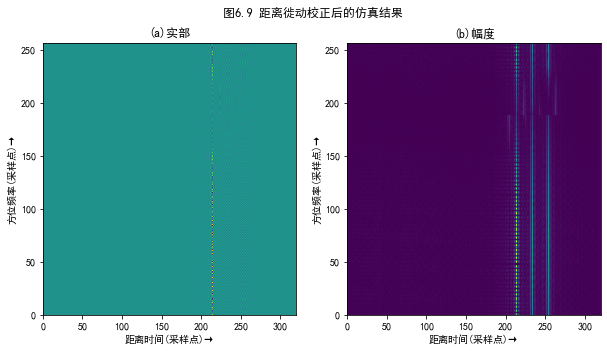

In [13]:
#  绘图
H8 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(Srcmf_tf_1))#set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(a)实部')
subplot(122),plt.pcolor( abs(Srcmf_tf_1))#set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(b)幅度')
suptitle('图6.9 距离徙动校正后的仿真结果')

Text(0.5, 0.98, '图6.9 距离徙动校正后的仿真结果')

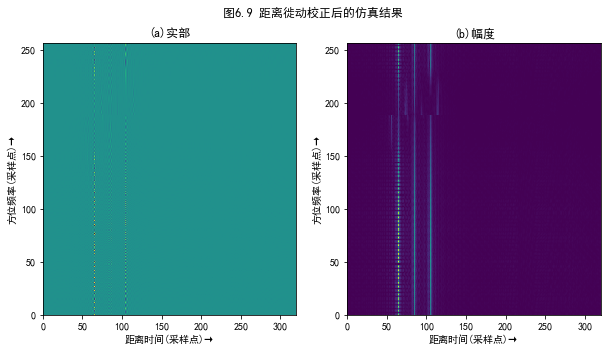

In [14]:
#  绘图
H9 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(Srcmf_tf_2))#set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(a)实部')
subplot(122),plt.pcolor( abs(Srcmf_tf_2))#set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(b)幅度')
suptitle('图6.9 距离徙动校正后的仿真结果')

Text(0.5, 0.98, '图6.9 距离徙动校正后的仿真结果')

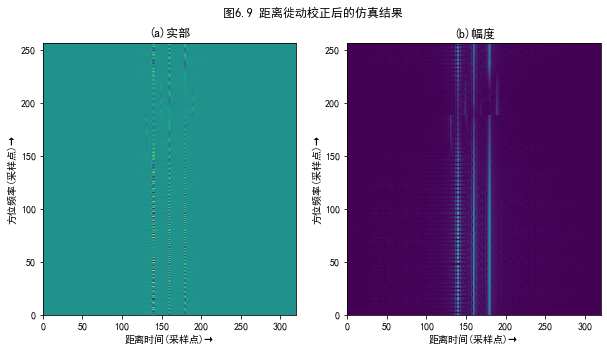

In [15]:
#  绘图
H10 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(Srcmf_tf_3))#set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(a)实部')
subplot(122),plt.pcolor( abs(Srcmf_tf_3))#set(gca,'YDir','normal')
xlabel('距离时间(采样点)→'),ylabel('方位频率(采样点)→'),title('(b)幅度')
suptitle('图6.9 距离徙动校正后的仿真结果')

Text(0.5, 0.98, '图6.9 方位压缩后的仿真结果')

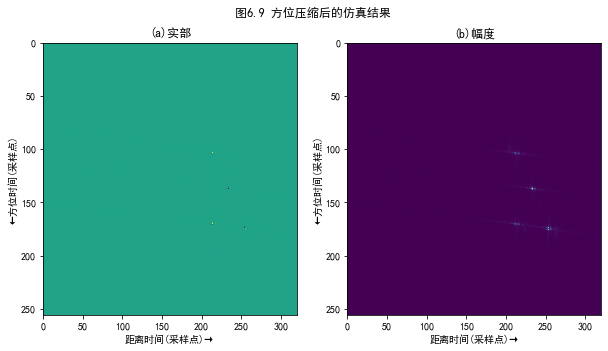

In [22]:
## 信号设置--》方位压缩
#  变量设置
Ka = 2*Vr**2*cos(theta_r_c)**2/(lambda0*r_tauX); 
#  计算滤波器
Haf = exp(-1j*pi*f_etaY**2/Ka);
Haf_offset = exp(-1j*2*pi*f_etaY*t_eta_c);
#  匹配滤波
Soutf_tf_1 = Srcmf_tf_1*Haf*Haf_offset;
soutt_tt_1 = ifft(Soutf_tf_1,Naz,axis=0);
Soutf_tf_2 = Srcmf_tf_2*Haf*Haf_offset;
soutt_tt_2 = ifft(Soutf_tf_2,Naz,axis=0);
Soutf_tf_3 = Srcmf_tf_3*Haf*Haf_offset;
soutt_tt_3 = ifft(Soutf_tf_3,Naz,axis=0);
## 绘图
H11 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(soutt_tt_1))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(a)实部')
subplot(122),plt.pcolor( abs(soutt_tt_1))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(b)幅度')
suptitle('图6.9 方位压缩后的仿真结果')

Text(0.5, 0.98, '图6.9 方位压缩后的仿真结果')

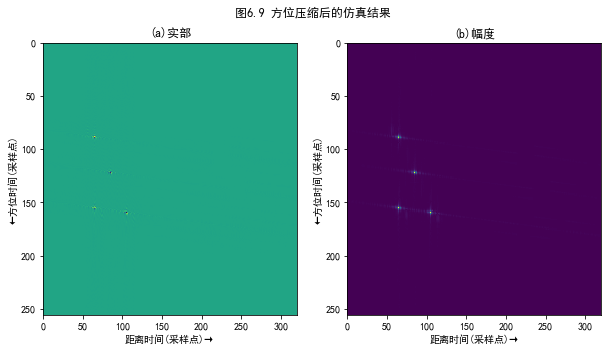

In [23]:
## 绘图
H12 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(soutt_tt_2))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(a)实部')
subplot(122),plt.pcolor( abs(soutt_tt_2))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(b)幅度')
suptitle('图6.9 方位压缩后的仿真结果')

Text(0.5, 0.98, '图6.9 方位压缩后的仿真结果')

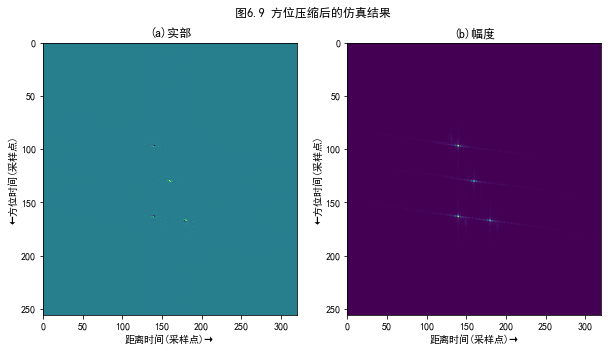

In [24]:
## 绘图
H13 = figure(figsize=(10,5));
subplot(121),plt.pcolor(real(soutt_tt_3))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(a)实部')
subplot(122),plt.pcolor( abs(soutt_tt_3))
plt.gca().invert_yaxis()
xlabel('距离时间(采样点)→'),ylabel('←方位时间(采样点)'),title('(b)幅度')
suptitle('图6.9 方位压缩后的仿真结果')

Text(0.5, 0.98, '方位压缩后的仿真结果-实部')

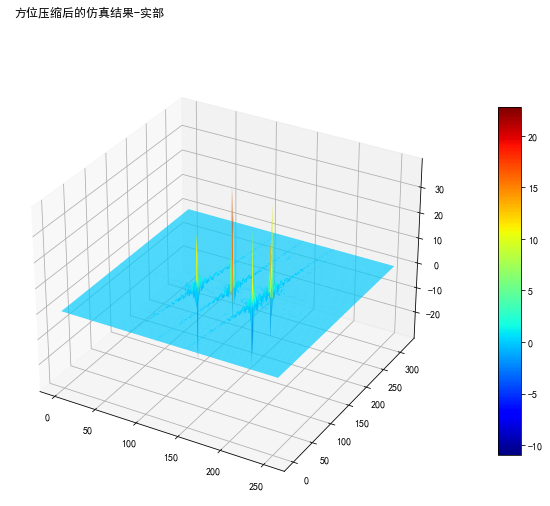

In [19]:
fig=plt.figure(figsize=(20,8))
x = range(Naz)
y = range(Nrg)
xx, yy = np.meshgrid(x, y )  # 转换成二维的矩阵坐标
sub=fig.add_subplot(111,projection='3d')#3d表示三维图像
rr = real(soutt_tt_3)
surf=sub.plot_surface(xx,yy,rr[xx,yy],rstride=1, cstride=1, cmap='jet', edgecolor='none')#设置渐变色
cb=fig.colorbar(surf,shrink=0.8,aspect=15)#添加颜色棒,shrink表示缩放,aspect表示宽
# cb.set_ticks([0,0.5,1,np.sqrt(2)]/np.sqrt(2))
# cb.ax.set_yticklabels(['0','0.5','1',r'$\sqrt{2}$'])#设置颜色棒刻度标签

suptitle('方位压缩后的仿真结果-实部')

Text(0.5, 0.98, '方位压缩后的仿真结果-虚部')

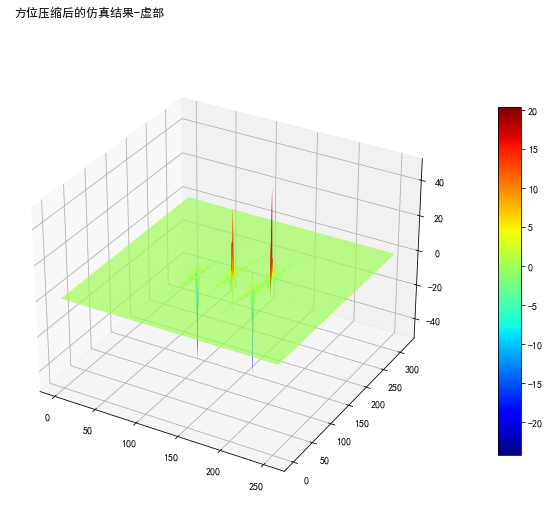

In [20]:
fig=plt.figure(figsize=(20,8))
x = range(Naz)
y = range(Nrg)
xx, yy = np.meshgrid(x, y )  # 转换成二维的矩阵坐标
sub=fig.add_subplot(111,projection='3d')#3d表示三维图像
rr = imag(soutt_tt_3)
surf=sub.plot_surface(xx,yy,rr[xx,yy],rstride=1, cstride=1, cmap='jet', edgecolor='none')#设置渐变色
cb=fig.colorbar(surf,shrink=0.8,aspect=15)#添加颜色棒,shrink表示缩放,aspect表示宽
# cb.set_ticks([0,0.5,1,np.sqrt(2)]/np.sqrt(2))
# cb.ax.set_yticklabels(['0','0.5','1',r'$\sqrt{2}$'])#设置颜色棒刻度标签

suptitle('方位压缩后的仿真结果-虚部')

Text(0.5, 0.98, '方位压缩后的仿真结果-幅度')

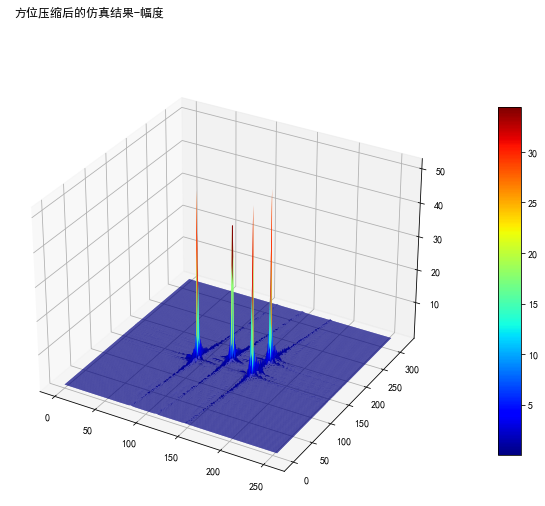

In [21]:
fig=plt.figure(figsize=(20,8))
x = range(Naz)
y = range(Nrg)
xx, yy = np.meshgrid(x, y )  # 转换成二维的矩阵坐标
sub=fig.add_subplot(111,projection='3d')#3d表示三维图像
rr = abs(soutt_tt_3)
surf=sub.plot_surface(xx,yy,rr[xx,yy],rstride=1, cstride=1, cmap='jet', edgecolor='none')#设置渐变色
cb=fig.colorbar(surf,shrink=0.8,aspect=15)#添加颜色棒,shrink表示缩放,aspect表示宽
# cb.set_ticks([0,0.5,1,np.sqrt(2)]/np.sqrt(2))
# cb.ax.set_yticklabels(['0','0.5','1',r'$\sqrt{2}$'])#设置颜色棒刻度标签

suptitle('方位压缩后的仿真结果-幅度')

本文Python代码参照Matlab代码自：https://github.com/wanghs008/SAR-SignalProcessing